# Solvers for Traffic Engineering

This tutorial provides hands-on experiences with solving flow formulations for different aspects of centralized Traffic Engineering. It covers the following concepts

* Prerequisites
  * Data-structures and libraries for solving network flow problems
* Multi-commodity Traffic Engineering solving as linear programming
  * A basic solver for multi-commodity TE with maximal flow objectives
  * A basic solver based on hybrid objectives
* Network provisioning
  * Illustrated using Shoofly 
* Traffic Engineering in the presence of planning for failures
  * A non-scalable formulation of Forward Fault Correction (FFC)
  * A scalable formulation of FFC using linear programming duality 
  


# Prerequisites

## Dependencies
Our tutorial code depends on two libraries that do not come with standard Python distributions or may require updates. They can be installed using pip. If installation fails from juypter try to install from the command line.


In [1]:
#!pip install cvxpy
#!pip install networkx
#!pip install -U matplotlib

## Libraries
We have coded basic datastructures for networks, for parsing networks, and for encapsulating Mixed Integer Programming, MIP, solvers in self-contained files. We load these as other libraries. You are invited to look at these files for details on how we represent networks and interface with MIP.

In [2]:
from NetworkTopology import *
from NetworkParser import *
from TESolver import *
from MIPSolver import *
from helper import *

## Load the network topology, tunnels and demands

For this tutorial we use a small network, B4, to illustrate algorithms.
We use a library routine for computing K-shortest paths to allocate tunnels to B4.
Note that state-of-art TE systems compute tunnels using much more sophisticated 
means: they consider path diversity, congestion, and network utilization. 
It is beyond the scope of this tutorial to cover these techniques.

Let us set up the "b4" network. The topology is saved in a csv file from where it can be loaded.

* Parse the public B4 topology and traffic demands
* Use K-shortest paths as tunnels used by traffic engineering
* Initialize equal weights on all edges of the network

In [3]:
network_name = "b4"
network = parse_topology(network_name)
parse_demands(network)
parse_tunnels(network)
initialize_weights(network)

## Plot the topology of the network

Plot the network topology with datacenters as the nodes and capacities on bi-directional edges.

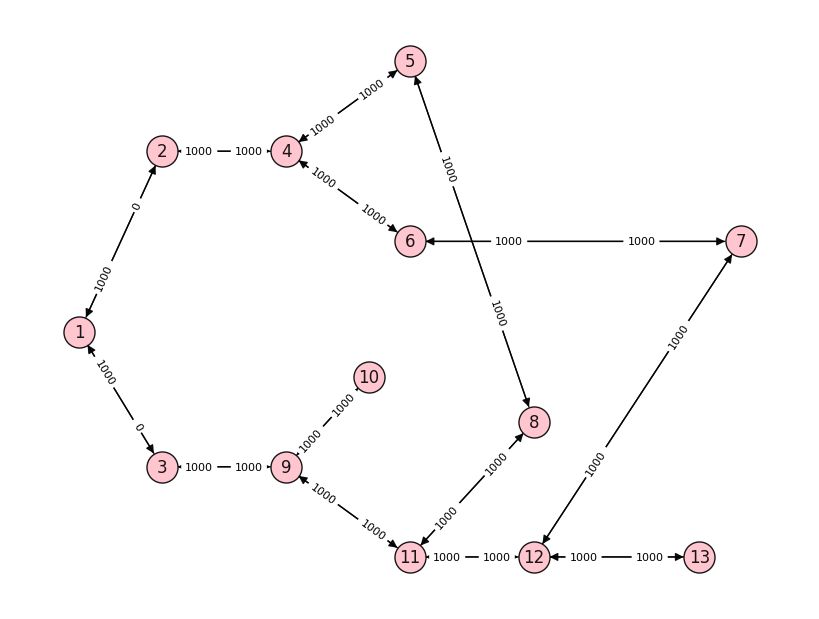

In [4]:
G = network.to_nx()
capacity_labels = { edge : network.edges[edge].capacity for edge in G.edges } 
network.draw(capacity_labels)

# Multi-commodity Traffic Engineering solving as linear programming


Basic traffic engineering problem can be cast as a multi-commodity flow optimization problem. 
A basic objective is to maximize flow. We will assume we are given a network, demands and tunnels
and use the following notation:

<div class="alert alert-block alert-info">
    
* $G: \langle V,E\rangle$:  network $G$, vertices $V$ and edges $E$
* $c_{e}$:  capacity of edge $e$
* $D$: set of traffic demands between source and destination vertices
* $demand(d)$:  traffic demand between $src_{d}$ and $dst_{d}$ for $d \in D$.
* $T(d)$: set of tunnels over demand $d$. Each tunnel is a path from $src_d$ to $dst_d$ for some demand $d$.
* $f(t)$: flow through tunnel $t$.

</div>

_We use a blue box for definitions of input, auxiliary and output variables_

Assume each edge $e$ in a network has capacity $c_e$, and each demand $d$ has associated a set of tunnels.
Then,

* for each edge $e$, the flows on tunnels traversing $e$ must not exceed the capacity $c_e$.

Since the flow allocation for each demand needs not exceed the demand requirement, we can cap the
flow at the demands while posing the objective to maximize overall flows and therefore minimize the gap 
between allocated flows and required demand. As a linear program:

<div class="alert alert-block alert-success">
    
Maximize $\sum f(t)$

Subject to 

* $c_e \geq \sum_{t \ni e} f(t)$ for each edge $e$
* $demand(d) \geq \sum_{t \in T(d)} f(t)$ for each demand $d$

</div>

_We use a green box for definitions of optimization constraints_

We solve the max flow problem on our sample network by
* creating a MIP solver (we here use the CVX library)
* creating a TE solver using a MIP solver and a network
* adding the two sets of linear constraints
* setting the maximization objective to a max flow

Note that we are so far only using linear programming over reals (and do not require solving with integers)

In [5]:
mip = CvxSolver()
solver = TESolver(mip, network)
solver.add_demand_constraints()
solver.add_edge_capacity_constraints()
solver.Maximize(get_max_flow_objective(network))

max_flow = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Max flow:", max_flow)

Optimal solution was found.
Max flow: 1269.9999999183106


## Visualize the results

* Plotting the total flow allocation on each edge.
* Note that edges are bi-directional 
  * so the flow from node A to node B is shown closer to the node B.

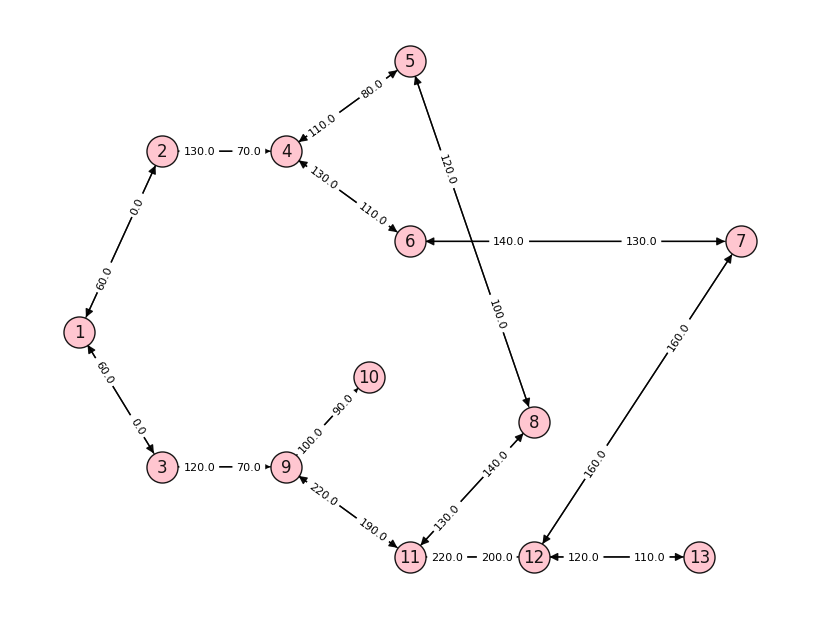

In [6]:
network.draw(get_edge_flow_allocations(network))

##  Were all traffic demands met?

* get_demands_unmet calculates the gaps between the flow allocated by each demand and the flow required by a demand.
* If all gaps are 0, the demands are met.

In [7]:
if sum(get_demands_unmet(network).values()) == 0:
    print("All demands were met.")
else:
    print("Not all traffic demands could be met")
    print("Unmet demands: " + str(sum(get_demands_unmet(network).values())))

Not all traffic demands could be met
Unmet demands: 290


## Traffic engineering with max flow and minimum latency

Let us change the objective from computing pure maximal flows to 
also achieve maximum flow with low latency.

We here use link weights as a measure for latency.
The new objective is now a weighted linear combination of maximizing the sum $f(t)$ and minimizing
the latency contributed by each flow. 

* We use $\epsilon$ as the weight to assign to latency.
* The weight of a tunnel $weight(t)$ is the sum of weights of links $\sum_{e\in t} weight(e)$.

* The objective is now:

<div class="alert alert-block alert-success">
    
  Maximize $\sum f(t) \cdot (1 - \epsilon \cdot weight(t))$ 
  
</div>

Optimal solution was found.
Objective: 543.9999999635411


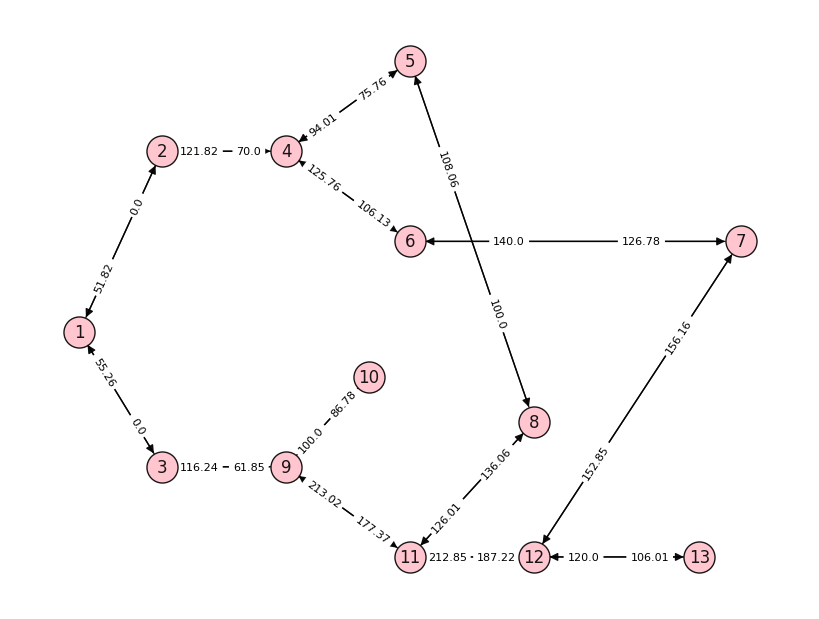

In [8]:
objective = get_max_flow_min_weight_objective(network, epsilon=0.1)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Objective:", obj)
network.draw(get_edge_flow_allocations(network))

# Networking Provisioning with Shoofly

We will now consider an instance of _network provisioning_. In contrast to online TE, provisioning is performed offline and using long-term forecasts of network traffic patterns. The objectives of provisioning is to allocate hardware resources, namely links and ports. Shoofly focuses on allocation of ports by identifying network hops that can be bypassed.


Using traffic engineering principles, we solve the capacity provisioning problem. In usual cases, TE allocates traffic to meet as much demand as is possible. However, in provisioning, TE must meet all the demands while allocating traffic to certain edges.

Shoofly assumes we are given, as input, a network together with a set of possible shortcuts and an annotation of number of wavelengths are allocated on each edge:

<div class="alert alert-block alert-info">

* $u_{e}$:  capacity of one wavelength of edge $e$
* $s$:  network shortcut due to optical bypass
* $u_{s}$:  capacity of one wavelength of shortcut $s$

</div>

We introduce auxiliary and output variables:

<div class="alert alert-block alert-info">
            
* $w_s$: the number of wavelengths assigned to shortcut $s$. Note that $w_s$ is an _integer_. Shoofly requires _Mixed Integer Programming_.
* $x^t_e$: the flow allocated to tunnel $t$ that traverses edge $e$
* $y^t_s$: the number of wavelengths allocated to shortcut $s$ as part of tunnel $t$.

</div>

Shoofly then solves an optimization problem where savings are measured in number of ports saved by using shortcuts.

<div class="alert alert-block alert-success">
    
Maximize $\sum_s |s| \cdot w_s$

</div>

The optimization problem is subject to allocating flows to tunnels and shortcuts that meet all forecast demands.
The formalization is explained in the <a href="http://shoofly.network/">online Shoofly Material</a>. 
We recall the main constraints here:




    
<div class="alert alert-block alert-success">
    


\begin{array}{lll}
\mbox{flows can be allocated to meet all demands} & demand(d) \leq \sum_{t \in d} f(t) & \mbox{for each demand $d$} \\
\mbox{allocated flows don't exceed the edge capacities} & \sum_{t \ni e} x^t_e + e_u\cdot \sum_{s \ni e} w_s \leq e_c & \mbox{for each edge $e$} \\
\mbox{flow passing through each shortcut is}  & \sum_{t \in s} y^t_s \leq u_s \cdot w_s                     & \mbox{for each shortcut $s$} \\
\mbox{bounded by wavelengths assigned to $s$} & & \\
\mbox{shortcuts are assigned on duplex links} & w_s = w_{s'}                                                & \mbox{for each $s, s'$ such that $s' = reverse(s)$} \\
\mbox{so have to be the same in both link directions} & & \\
\mbox{the flow in a tunnel $t$ is capped at} & f(t) \leq x^t_e + \sum_{s \ni e} y^t_s & \mbox{for every tunnel $t$, and edge $e\in t$} \\
\mbox{the contribution of each edge to $t$} & & 
\end{array}

<!--
    
* add_demand_constraints: 
  * flows can be allocated to meet all demands
  * $demand(d) \leq \sum_{t \in d} f(t)$ for each demand $d$
* add_edge_capacity_constraints: 
  * allocated flows don't exceed the edge capacities
  * $\sum_{t \ni e} x^t_e + e_u\cdot \sum_{s \ni e} w_s \leq e_c$ for each edge $e$
* add_wavelength_integrality_constraints: 
  * flow passing through each shortcut is bounded by wavelengths assigned to $s$.
  * $\sum_{t \in s} y^t_s \leq u_s \cdot w_s$ for each shortcut $s$
* add_complementary_shortcut_constraints: 
  * shortcuts are assigned on duplex links so have to be the same in both link directions
  * $w_s = w_{s'}$ for each $s, s'$ such that $s' = reverse(s)$.
* add_flow_conservation_constraints: 
  * the flow in a tunnel $t$ is capped at the contribution of each edge to $t$
  * $f(t) \leq x^t_e + \sum_{s \ni e} y^t_s$ for every tunnel $t$, and edge $e\in t$.
  
-->
    
</div>

In [9]:
mip = CvxSolver()
solver = ShooflySolver(mip, network)
solver.add_demand_constraints()
solver.add_edge_capacity_constraints()
solver.add_wavelength_integrality_constraints()
solver.add_complementary_shortcut_constraints()
solver.add_flow_conservation_constraints()
objective = get_wavelength_objective(network)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution found:", obj)
else:
    print("Optimal solution not found.")

Optimal solution not found.


# Analyze the new network topology
The solver find wavelengths that can bypass regions. This in turn leads to a redistribution of capacity from the existing edges to the shortcuts. 
* First, update the edge capacities using the solver's output. 
* Add the new edges resulting from optical bypass.
* Visualize the new network topology.

In [10]:
for shortcut in solver.network.shortcuts.values():
    shortcut_capacity = shortcut.w_s.value * shortcut.unity
    network.update_with_shortcuts(shortcut.pathstr, shortcut_capacity, shortcut.unity, int(shortcut.w_s.value))    

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

# Proposed network topology
Bypass leads to the removal of certain edges and the addition of new ones. The capacity of some edges from the original topology has been reduced to better cater to the demands while maximizing bypass-enabled cost savings.

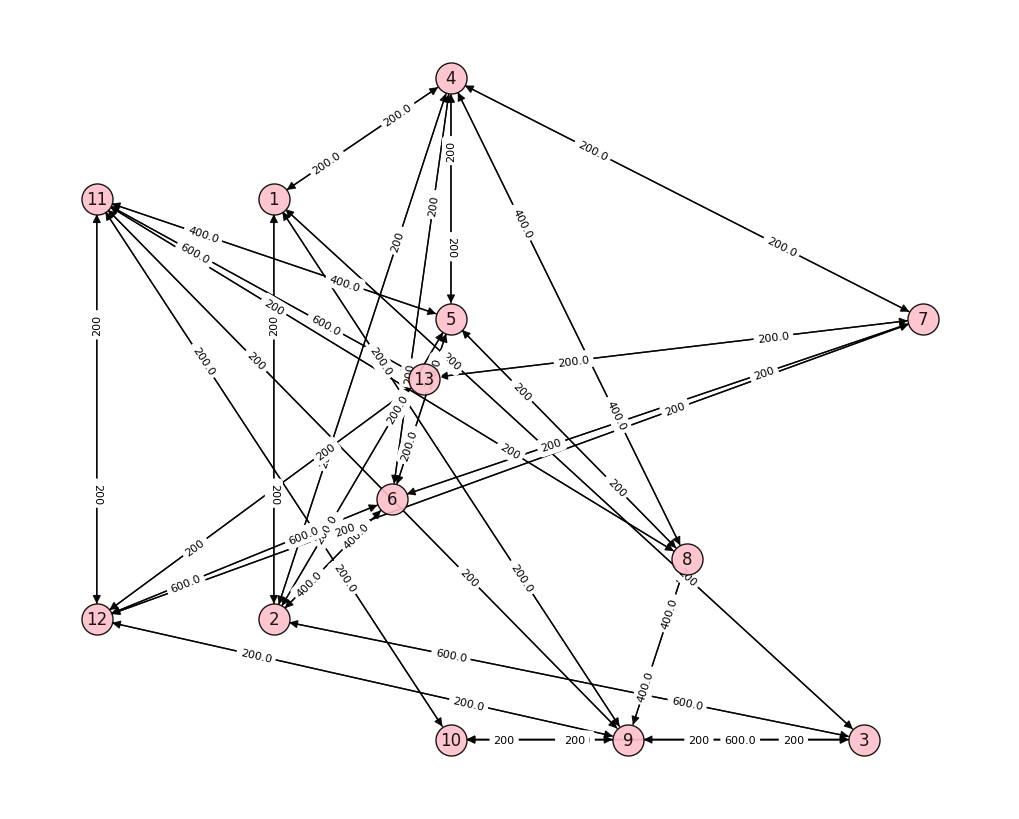

In [ ]:
network.remove_zero_capacity_edges()
G = network.to_nx()
capacity_labels = { edge : network.edges[edge].capacity for edge in G.edges } 
network.draw(capacity_labels)

## Restore the original network

In [ ]:
network_name = "b4"
network = parse_topology(network_name)
parse_demands(network)
parse_tunnels(network)
initialize_weights(network)

# Forward-fault correction

Traffic Engineering with [Forward-Fault Correction, FFC](http://www.sigcomm.org/node/3715), seeks a flow allocation that is maximally resilient to a set of failure scenarios. 


## Failure Groups
We encode each failure scenario using a _failure group_.
Each failure group contains a set of edges that are disabled when the failure occurs.

<div class="alert alert-block alert-info">

* $G$ - a failure group
* $F$ - a set of failure groups

</div>

### Pairwise Failures

A common scenario is to consider pairwise failures. Thus, for a network with set of edges $E$, the failure groups $F$ are all pairs of edges from $E$.

* $F = \{ \{ e, e' \} \mid e, e' \in E \}$

### Characteristic Functions
A failure group $G$ determines a characteristic function $\alpha$ defined on edges and tunnels:

* $\alpha(e) = 0$ if $e \in G$, else $ = 1$.
* $\alpha(t) = \alpha(e_1) \cdots \alpha(e_k)$ where $t = e_1, \ldots, e_k$.

_Note that the characteristic functions are integer variables with only possible values $0$ or $1$_.

## FFC Constraints

Then the following constraints solve for a flow $f(t)$, such that edge capacities are not exceeded and the worst case failure scenario bandwdith allocation for a demand $d$ is $b_d$. The FFC TE goal is to minimize the accumulated gap between $b_d$ and the demand $d$.

<div class="alert alert-block alert-info">
   
* $b_d$: worst case bandwidth allocation for demand $d$.

</div>

<div class="alert alert-block alert-success">
    
Maximize $\sum_d b_d$

Subject to


* $\sum_{t \ni e} f(t) \leq c_e$ for each edge $e$
* $b_d \leq \sum_{t \in d} \alpha(t) \cdot f(t)$ for each demand $d$, each failure scenario $\alpha \in F$
* $b_d \leq demand(d)$ for each demand $d$
* $0 \leq f(t)$ each tunnel $t$

</div>


Optimal solution was found.
Optimal objective: 8.691083922960057e-11


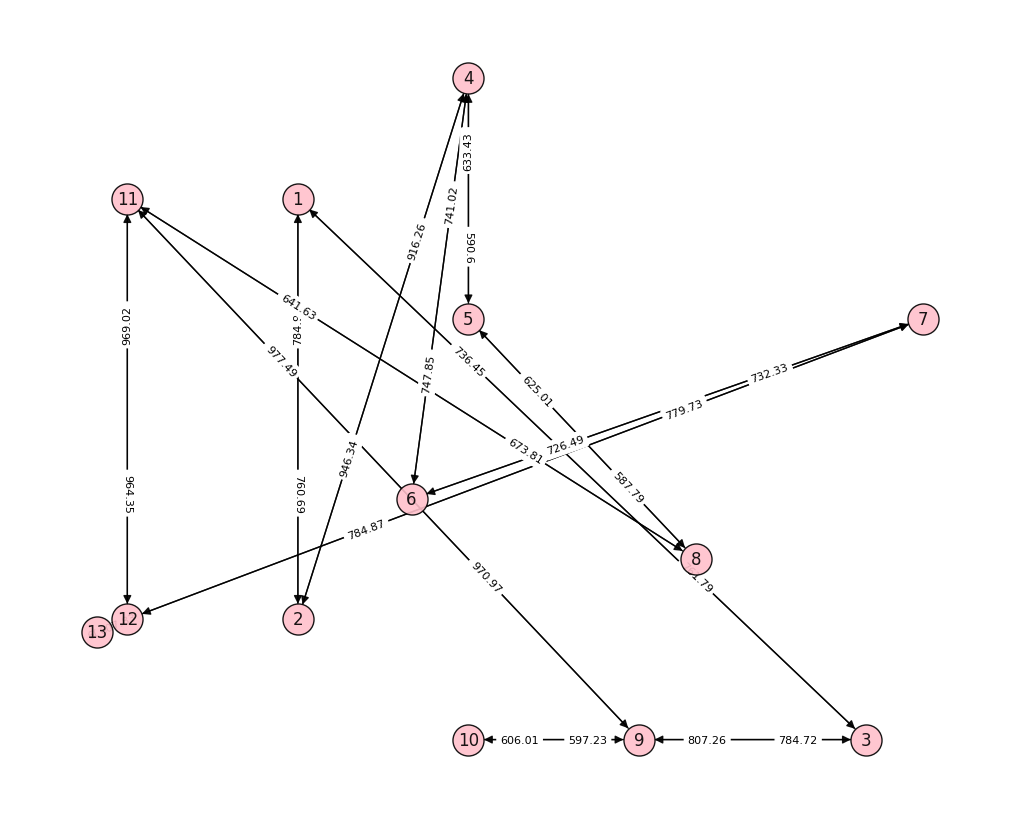

In [ ]:
mip = CvxSolver()
solver = FFCSolver(mip, network)
solver.add_demand_constraints()
solver.add_edge_capacity_constraints()

# Enumerate single link failures (k = 1)
for edge in network.edges:
    # edges are directional tuples, thus, failing (a,b) implies that (b,a) also fails.
    edges = set([network.edges[edge], network.edges[edge[::-1]]])
    solver.failure_scenario_edge_constraint(edges)

objective = get_ffc_objective(network)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Optimal objective:", obj)
else:
    print("Optimal solution was not found.")

network.draw(get_edge_flow_allocations(network))

## Optimizing FFC using Linear Programming Duality

Solving the straight-forward FFC formulation is not scalable: 
the set of pairwise failure scenarios grows quadratically with the size of the network. 
Luckily we can draw on fundamentals of linear programming to develop a formulation that only grows modestly with the network size. This observation was made in [a technical note](http://www.hongqiangliu.com/uploads/5/2/7/4/52747939/ffc-improve.pdf). [Lancent](https://engineering.purdue.edu/~isl/papers/Sigmetrics2020_Lancet.pdf) develops a general setting that exploits duality. We here provide an updated rehash of FFC in light of exploiting linear programming dualities.


## Linear Programming Duality
A consequence of (strong) linear programming duality is the equation:

*	$\min \{ c x \mid A x \geq b, x \geq 0 \} = \max \{ b^T y \mid A^T y \leq c, y \geq 0 \}$


It holds when $x, y$ range over reals. It also hold in important cases where $x$ range over integers.
The case we will exploit is when $A$ is totally unimodular.

We will be exploiting this duality to turn a nested optimization problem, where maximization and minimization are nested into a flat optimization problem with only maximization objectives. The advantage is a dramatic reduction in problem size for the non-nested problem. 

## From Primal to Dual FFC

Let us recall traffic engineering formulation under forward fault correction. 
The primary goal is to optimize throughput under a set of failure scenarios $F$. We use $\alpha(t)$
as an indicator for whether tunnel $t$ fails in one of the scenarios in the set $F$.
The value of $\alpha(t)$ is 0 if the tunnel is failed in scenario $\alpha$, 
otherwise, when the tunnel is operational, it is 1.

<div class="alert alert-block alert-success">
    
Maximize $\sum_d b_{d}$

Subject to

* $ b_{d} \leq \sum_{t \in d} \alpha(t) \cdot f(t) \ \  \forall d, \alpha \in F$
* $ b_{d} \leq demand(d) \ \  \forall d$
* $0 \leq f(t)  \ \ \  \forall t$
* $\sum_{t \ni e} f(t) \leq c_e  \forall e$
</div>


## As Minimization

For each demand $d$, the conjunction of constraints ranging over $\alpha$ 
is equivalent to bounding $b_{d}$ by the _minimial_ term 
$\sum_{t \in d} \alpha(t) \cdot f(t)$. Thus, we have the following equivalent
formulation:

<div class="alert alert-block alert-success">

Maximize $\max \sum_{d} b_{d}$

Subject to

* $b_{d} \leq \min_{\alpha \in F} \sum_{t \in d} \alpha(t) \cdot f(t)$  $\forall d$ 
* $0 \leq b_{d} \leq demand(d)$  $\forall d$
* $0 \leq f(t)$                  $\forall t$ 
* $\sum_{t \ni e} f(t) \leq c_e$ $\forall e$

</div>

## Failure Scenarios as constraints
When failure scenarios are given by $k$-wise edge failures the set of all possible $\alpha(t)$
can be characterized by a formula $F$ over variables $\alpha(t)$ and $\alpha(e)$ for each
tunnel $t$ and edge $e$ as follows:

\begin{align}
\alpha(t) \leq \alpha(e) \ & \ \ \forall t, e \in t \label{eq:inner-dual1} \\
\alpha(e) \leq 1 \ &  \ \ \forall \ e \label{eq:inner-dual2} \\
  \displaystyle \sum_{e \in t} \alpha(e) - \alpha(t) \leq |t| - 1 \ &  \ \ \forall t \label{eq:inner-dual3} \\
  \displaystyle \sum_{e\in E} \alpha(e) \geq |E| - k & \label{eq:inner-dual4} \\
  \alpha(e) \geq 0 & \ \ \forall e & \\
  \alpha(t) \geq 0 & \ \ \forall t & 
\end{align}

The first equation forces $\alpha(t)$ to 0 whenever some edge on $t$ has $\alpha(e) = 0$.
The second equation sets an upper bound on $\alpha(e)$.
The third equation forces $\alpha(t)$ to 1 whenever all edges on $t$ have $\alpha(e) = 1$.
The last equation ensures that at most $k$ edges have failed.
Note: the $\alpha$ variables are integers ranging over $0-1$.




## Dualizing $F$



We can dualize $F$ and convert the minimization problem into maximization (by exploiting strong duality).
For the dual of $F$, the dual variables are:

<div class="alert alert-block alert-info">

  * $y_{te}$ for each tunnel $t$, $e \in t$, a total of $T \times E$ 
  * $y_e$ for each edge e, a total of $E$ 
  * $y_t$ for each tunnel 
  * $y_f$ for the failure bound, a total of 1

</div>

and there are two sets of dual inequalities, one set for each tunnel another for the columns corresponding to edges.

\begin{array}{lll}
\displaystyle y_t - \sum_{e \in t} y_{te}  \leq f(t) & & \forall t \\
\\
\displaystyle \sum_{t \ni e} (y_{te} - y_t) - y_e + y_f \leq 0  & & \forall e
\end{array}

Call the resulting system of inequalities $F^D$.

<div class="alert alert-block alert-warning">
    
__Example__: We consider a single tunnel with two edges $e_1, e_3$.
The primal inequalities and their corresponding dual variables are:

\begin{array}{lrrrrlllllll}
y_{te_1}: & -\alpha(t)  & +\alpha(e_1) &                &               & \geq & 0 \\
y_{te_3}: & -\alpha(t)  &              &                & + \alpha(e_3) & \geq & 0 \\
y_{e_1} : &            & -\alpha(e_1)  &                &               & \geq & -1 \\
y_{e_2} : &            &              & -\alpha(e_2)    &               & \geq & -1 \\
y_{e_3} : &            &              &                & -\alpha(e_3)   & \geq & -1 \\
y_t  :    &  \alpha(t) & - \alpha(e_1) &               & - \alpha(e_3)  & \geq & 1 - |t| \\
y_f  :    &            &   \alpha(e_1) & + \alpha(e_2) & + \alpha(e_3) & \geq & |E| - k
\end{array}

The transposed, dual, matrix inequality is then:

\begin{array}{llllllllllll}
\alpha(t)   : &  -y_{te_1}  &    & - y_{te_3} &          &         &           & +y_t & & \leq & f(t) \\
\alpha(e_1) : &  y_{te_1} &    &            & -y_{e_1} &         &           & -y_t & +y_f & \leq & 0 \\
\alpha(e_2) : &            &    &            &          & -y_{e_2} &           &      & +y_f & \leq & 0 \\
\alpha(e_3) : &            &    &  y_{te_3} &          &         & - y_{e_3}  & - y_t & +y_f & \leq & 0 
\end{array}

</div>



We now have the equality:

*	$\min_{\alpha \in F} \sum_{t \in d} \alpha(t) \cdot f(t) \ \ =\ \  
	\max_{y \in F^D} \left((|E| - k)y^d_f - \sum_{e \in E_d} y^d_e + \sum_{t \in d} (1 - |t|)y^d_t\right)$

and therefore the new optimization problem:

<div class="alert alert-block alert-success">
    
Maximize $\sum_d b_{d}$

Subject to

*  $b_{d} \leq \max_{y \in F^D} ((|E| - k)y^d_f - \sum_{e \in E_d} y^d_e + \sum_{t \in d} (1-|t|)y^d_t) \ \  \forall d$
*  $0 \leq b_{d} \leq demand(d) \ \  \forall d$
*  $0 \leq f(t)  \ \ \  \forall t$
*  $\sum_{t \ni e} f(t) \leq c_e  \forall e$

</div>

The maximization objective is not required in the overall setting: the maximal bound satisfies the inequality if and only if some bound satisfies the inequality.
We therefore have the resulting flat set of inequalities:

<div class="alert alert-block alert-success">
    
Maximize $\sum_{d} b_{d}$

Subject to

\begin{array}{llll}
  &   \displaystyle  b_{d} \leq (|E| - k)y^d_f - \sum_{e \in E_d} y^d_e + \sum_{t \in d} (1-|t|)y^d_t  &   \forall \ d \\
  &   \displaystyle y^d_{t} - \sum_{e \in t} y^d_{te} \leq f(t)         & \forall \ d, \ t \in d\\
  &   \displaystyle \sum_{t \ni e} (y^d_{te} - y^d_{t}) - y^d_{e} + y^d_{f} \leq 0  & \forall \ d, \ e \ \in \ t \in d \\
  &    0 \leq b_{d} \leq demand(d)  & \forall \ d \\
  &    0 \leq f(t)              &  \forall \ t \\
  &    \sum_{t \ni e} f(t) \leq c_e & \forall \ e \\
  &    0 \leq y^d_{\ast}        & \forall d, \ast
\end{array}

</div>



Optimal objective: 2.760924476487379e-12


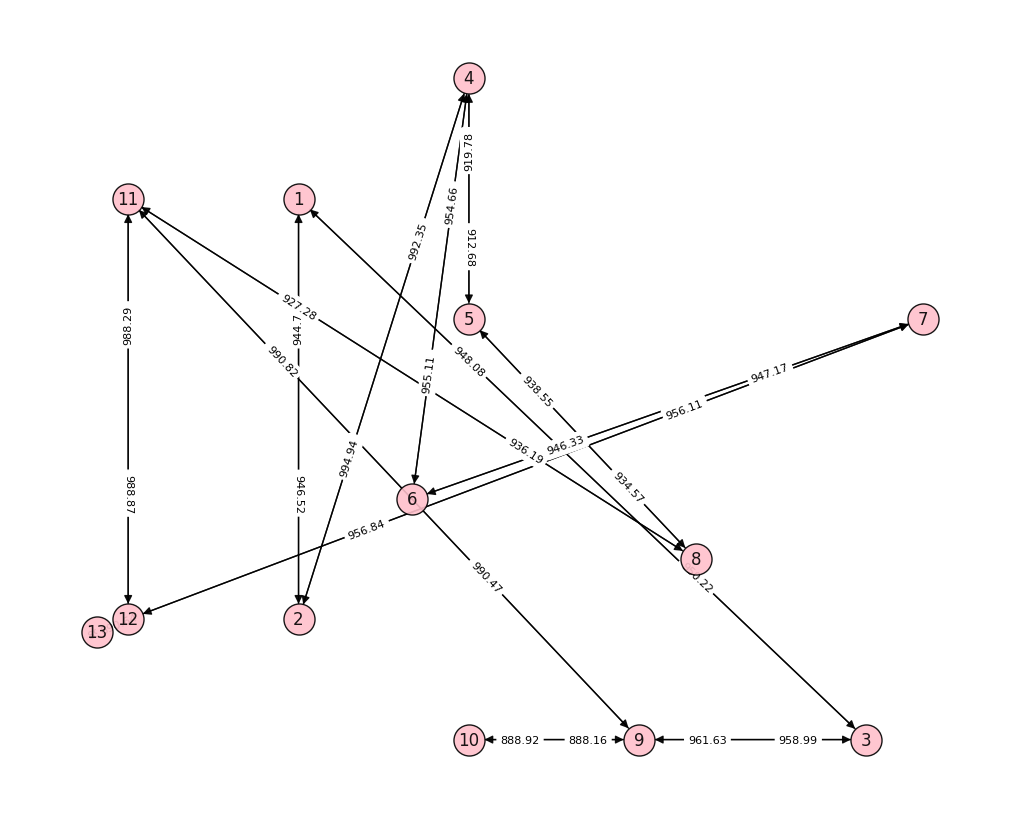

In [ ]:
mip = CvxSolver()
solver = DualFFCSolver(mip, network, 1)
solver.add_edge_capacity_constraints()
objective = get_ffc_objective(network)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal objective:", obj)
else:
    print("Optimal solution was not found.")
    
network.draw(get_edge_flow_allocations(network))

### Comparing Primal and Dual Formulations
Let us compare the overhead of formulating the primal and dual solutions.
For the primal:
* to bound $b_d$ requires $O(|D| \cdot |F|)$ inequalities.
* to bound $f(t)$ requires $O(|T| + |E|)$ inequalities.

For the dual, the number of dual variables is bounded by $|E| \cdot |D| + |T|$, where the contribution $|E| \cdot |D|$ is an over-estimate for counting each edge with a weight given by how many demands it participates in.

* to bound $b_d$ requires $O(|D|)$ inequalities using up to $O(|T| + |E|\cdot|D|)$ variables and $O(|D| \cdot |E|)$ inequalities using as many variables.
* to bound $f(t)$ requires $O(|T| + |E|)$ inequalities.

While the size of $F$ grows quadratically for pairwise failures, the size of the dual formulation is independent of how many failure scenarios are considered and we expect the contribution bounded by $|E|\cdot |D|$ to be relatively small as each demand would be served by a small fraction of $G$.
